<img src="images/dwave_leap.png" width="500 px" align="center">

# Getting Started with D-Wave - Part 1

Here, we provide an overview of working with Ocean.  The fundamental package of Ocean is _dimod_, a shared API for binary quadratic samplers. It provides a binary quadratic model (BQM) class that contains Ising and quadratic unconstrained binary optimization (QUBO) models used by samplers such as the D-Wave system. It also provides utilities for constructing new samplers and composed samplers and for minor-embedding. Its reference examples include several samplers and composed samplers.



In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

## Binary Quadratic Models

Binary Quadratic Models (BQM) are the fundamental object you can solve on the current quantum annealers. The represent the cost function of an optimization problem where the highest variable terms appearing are of second order i.e. quadratic. In the context of quantum annealing sometimes other terms are in use as well.

Binary Quadratic Models
- **QUBO** - Quadratic Unconstraint Binary Optimization with binary variables that assume the values $0$ and $1$
- **ISING** - physically motivated model with binary variables that assume the values $+1$ and $-1$

### QUBO

Quadratic unconstrained binary optimization. QUBO problems are traditionally used in computer science. Variables $x_i$ are TRUE and FALSE, states that correspond to 1 and 0 values. A QUBO problem is defined using an upper-diagonal matrix $Q$, which is an $N \times N$ upper-triangular matrix of real weights, and $x$, a vector of binary variables, as minimizing the cost function

$$
f(x) = \sum_{i} Q_{ii} x_i + \sum_{i \neq j} Q_{ij} x_i x_j \hspace{1.cm}\rm{with}\hspace{.3cm} x_i \in \{0,1\}
$$

where the diagonal terms $Q_{ii}$ are the linear coefficients and the nonzero off-diagonal terms are the quadratic coefficients $Q_{ij}$. 
Since the variabels fullfill $x_i^2=x_i$. This can be expressed more concisely as a single $N \times N$ matrix.

$$
f(x) = \sum_{i j} Q_{ij} x_i x_j = x^T Q x
$$

#### Representations

Let us as an example consider the QUBO 

$$Q = 7x - 9y +4z +xy +2xz -1.5yz$$

We can also represent that QUBO as a single $3 \times 3$ matrix which looks like that

$$
Q = 
\begin{pmatrix}
    7 &  1 &  2   \\
    0 & -9 & -1.5 \\
    0 &  0 & 4
\end{pmatrix}
$$

where by convention the lower half of the matrix is put to zero in order to same storage.

<img src="images/qubo_graph.jpg" width=800>

### ISING

In an Ising model the variables $s_i$ are “spin up” (↑) and “spin down” (↓), states that correspond to $+1$ and $−1$ values. The objective function expressed as an Ising model is as follows:

$$
f(x) = \sum_{i} h_{i} s_i + \sum_{i \neq j} J_{ij} s_i s_j \hspace{1.cm}\rm{with}\hspace{.3cm} s_i \in \{-1,1\}
$$

where the linear coefficients corresponding to qubit biases are $h_i$, and the quadratic coefficients corresponding to coupling strengths are $J_{ij}$.
Since the variabels fullfill $s_i^2 \neq s_i$ this can be not be expressed as a single matrix. Instead the matrix form of the Ising model reads:

$$
f(x) = h x + x^T J x
$$

Ising models can also be visualized as planar graphs.

## How to build a QUBO - Part 1

<img src="images/fe_1.jpg" width="800 px" align="center">

Given the above optimization problem, we need to construct the corresponding cost function which represents the energy landscape. We can construct this function using the following steps:

1. Initially our cost function is flat: $f_c(X)=0$
2. Add a term that lowers the cost function by $-1$, when friends are in the same group.
3. Add a term that lowers the cost function by $-1$, when enemies are in the same group.


In order to find the terms we need to add for enemies and friends, we start with the most general form of a QUDO term for two variables $x$ and $y$:

$$
ax + by + cxy + d
$$

and use a truth table to find the suitable coefficients $a,b,c,d$.

<img src="images/fe_3.jpg" width="800 px" align="center">

Thus, if $x$ and $y$ are friends, we find the cost function term

$$
x + y -2xy -1
$$

Following the same procedure for the enemies, we find the cost function term

$$
-x -y + 2xy
$$

With these terms we can construct the full QUBO for the above problem by adding all terms for the friend pairs $(x,y)$ and $(w,z)$ and the enemies $(y,z)$ which yields

$$
\rm{QUBO} = -2 +x +w -2xy +2yz -2wz
$$

Yeay!! We have a QUBO. Lets have a look at it...

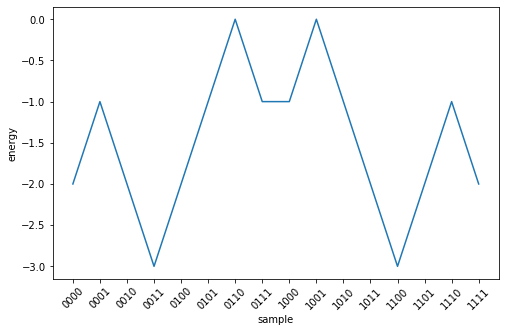

In [2]:
# define the QUBO function
def qubo(x,y,z,w):
    return -2 + x + w - 2*x*y + 2*y*z - 2*z*w

# plot the qubo
from utils.libex import plot_landscape
plot_landscape(qubo, n_qubits=4)

# Find the exact solution with Ocean 

In order to find the energies for all states with D-Wave Ocean, we use the __dimod.ExactSolver()__ command. But careful!! This is only realistic for very small problems.

In [3]:
import dimod
# define the solver
exactsolver = dimod.ExactSolver()

Next we need to transform our QUBO equation into the correct input format the DWAVE samplers will accept, which is basically a sparse matrix representation. We can read off the linear and quadratic terms directly to obtain the QUBO

In [4]:
# using the order: (x, y, z, w)
Q = {(0, 0): 1, (3, 3): 1, (0, 1): -2, (1, 2): 2, (2, 3): -2}

This form of our QUBO can be submitted to the sampler obtaining the exact results for the encoded problem.

In [5]:
bqm = dimod.BinaryQuadraticModel.from_qubo(Q, offset=-2.0)
results = exactsolver.sample(bqm)

# print the results
for sample, energy in results.data(['sample', 'energy']):
    print(list(sample.values()), energy)

[1, 1, 0, 0] -3.0
[0, 0, 1, 1] -3.0
[0, 0, 0, 0] -2.0
[1, 1, 0, 1] -2.0
[0, 1, 0, 0] -2.0
[1, 1, 1, 1] -2.0
[1, 0, 1, 1] -2.0
[0, 0, 1, 0] -2.0
[1, 0, 0, 0] -1.0
[0, 0, 0, 1] -1.0
[0, 1, 0, 1] -1.0
[1, 1, 1, 0] -1.0
[0, 1, 1, 1] -1.0
[1, 0, 1, 0] -1.0
[1, 0, 0, 1] 0.0
[0, 1, 1, 0] 0.0


# Solve optimization problem with Simulated Annealer

To test code and develop without using up cloud credits, Ocean provides the **neal** package, a backend for simulated annealing.

In [6]:
import neal
sampler = neal.SimulatedAnnealingSampler()
response = sampler.sample(bqm, num_reads=10)

In [7]:
for sample, energy in response.data(['sample', 'energy']):
    print(list(sample.values()), energy)

[0, 0, 1, 1] -3.0
[1, 1, 0, 0] -3.0
[0, 0, 1, 1] -3.0
[1, 1, 0, 0] -3.0
[0, 0, 1, 1] -3.0
[0, 0, 1, 1] -3.0
[0, 0, 1, 1] -3.0
[0, 0, 1, 1] -3.0
[1, 1, 0, 0] -3.0
[0, 0, 1, 1] -3.0


The samples are redundant thus lets aggregate the result to see just the unique solutions. 

In [8]:
for sample, energy in response.aggregate().data(['sample', 'energy']):
    print(list(sample.values()), energy)

[0, 0, 1, 1] -3.0
[1, 1, 0, 0] -3.0


Yeay! We found the optimal solutions.

## Questions:
- What is a BQM?
- What is the difference between Ising and QUBO models?
- Can every BQM by visualized as a graph?
- How is a quadratic term in a QUBO visualized in a graph?
- How do we find the optimal solution of a QUBO?
- Is there always just a single solution to a BQM? 

## Exercise: What happens if Xavier and Wanda are also friends?

<img src="images/fe_7.jpg" width="800 px" align="center">

In [9]:
Q = {(0, 0): 2, (3, 3): 2, (0, 1): -2, (1, 2): 2, (2, 3): -2, (0, 3): -2}
bqm = dimod.BinaryQuadraticModel.from_qubo(Q, offset=-3.0)
results = exactsolver.sample(bqm)

# print the results
for sample, energy in results.data(['sample', 'energy']):
    print(sample, energy)

{0: 0, 1: 0, 2: 0, 3: 0} -3.0
{0: 1, 1: 1, 2: 0, 3: 1} -3.0
{0: 1, 1: 1, 2: 0, 3: 0} -3.0
{0: 0, 1: 1, 2: 0, 3: 0} -3.0
{0: 1, 1: 1, 2: 1, 3: 1} -3.0
{0: 0, 1: 0, 2: 1, 3: 1} -3.0
{0: 1, 1: 0, 2: 1, 3: 1} -3.0
{0: 0, 1: 0, 2: 1, 3: 0} -3.0
{0: 1, 1: 0, 2: 0, 3: 0} -1.0
{0: 1, 1: 0, 2: 0, 3: 1} -1.0
{0: 0, 1: 0, 2: 0, 3: 1} -1.0
{0: 0, 1: 1, 2: 0, 3: 1} -1.0
{0: 0, 1: 1, 2: 1, 3: 0} -1.0
{0: 1, 1: 1, 2: 1, 3: 0} -1.0
{0: 0, 1: 1, 2: 1, 3: 1} -1.0
{0: 1, 1: 0, 2: 1, 3: 0} -1.0


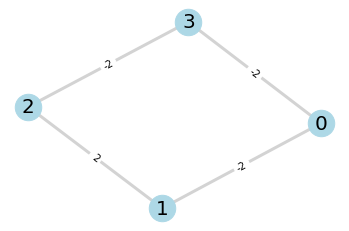

In [10]:
from utils.libqubo import show_bqm_graph
show_bqm_graph(bqm)